# Подключение библиотеки

In [107]:
import timeit
import time
import sys
import os
import re
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm.auto import tqdm
from IPython.display import display, HTML
from datetime import datetime

import matplotlib.pyplot as plt

from scipy import stats as st
# Тренды и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Проверка на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
# Проверка на дисперсию с помощью теста Андерсона-Дарлинга
from scipy.stats import anderson

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit

# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# Многозадачная регрессия
from sklearn.multioutput import MultiOutputRegressor
# Для машинного обучения
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
# Метод ближайшего соседа KNN
from sklearn.neighbors import KNeighborsRegressor
# Метод опорного вектора, SVR - для регрессии
from sklearn.svm import SVR

# Метрики
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

# Нейросети
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
# Для сборщика мусора
import gc

In [ ]:
try:
    from torchdiffeq import odeint  # Импортируем ODE-решатель
    from TorchDiffEqPack.odesolver import odesolve  # Заменяем пакет решателей ODE
except:
    !pip install torchdiffeq
    !pip install TorchDiffEqPack

    from torchdiffeq import odeint  # Импортируем ODE-решатель
    from TorchDiffEqPack.odesolver import odesolve  # Заменяем пакет решателей ODE

# Импорт и анализ данных

In [2]:
try:
    df = pd.read_csv('Amp_C_train.txt')
except:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            
    df = pd.read_csv(os.path.join(dirname, filename))

##### Рассмотрим содержимое датасет

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172032 entries, 0 to 172031
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    172032 non-null  float64
 1   Input   172032 non-null  object 
 2   Output  172032 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


In [4]:
# Приведение к нижнему регистру названия колонки
df.columns = df.columns.str.lower()

In [5]:
df.head()

,time,input,output
0,0.000000e+00,0j,(1.0785e-42-9.30535e-43j)
1,5.000000e-09,0j,(4.00167e-44+4.80805e-45j)
2,1.000000e-08,0j,(5.73102e-46+1.23143e-45j)
3,1.500000e-08,0j,(-2.47356e-47+3.89672e-47j)
4,2.000000e-08,0j,(-1.56497e-48+2.91821e-51j)


# Предобработка данных

## Сделаем датасет в временной ряд

In [6]:
# Установка колонки 'time' в качестве индекса
df.set_index('time', inplace=True)

## Преобразование комплексных входных и выходных сигналов из строкового представления

In [7]:
df['input'] = df['input'].apply(lambda x: complex(x.strip('()').replace('i', 'j')))
df['output'] = df['output'].apply(lambda x: complex(x.strip('()').replace('i', 'j')))

## Изменим DataFrame с реальной и мнимой частями комплексных чисел

In [8]:
df['input_real'] = df['input'].apply(np.real)
df['input_imag'] = df['input'].apply(np.imag)
df['output_real'] = df['output'].apply(np.real)
df['output_imag'] = df['output'].apply(np.imag)

In [9]:
df.head()

,input,output,input_real,input_imag,output_real,output_imag
time,,,,,,
0.000000e+00,0.0+0.0j,1.078500e-42-9.305350e- 43j,0.0,0.0,1.078500e-42,-9.305350e-43
5.000000e-09,0.0+0.0j,4.001670e-44+4.808050e- 45j,0.0,0.0,4.001670e-44,4.808050e-45
1.000000e-08,0.0+0.0j,5.731020e-46+1.231430e- 45j,0.0,0.0,5.731020e-46,1.231430e-45
1.500000e-08,0.0+0.0j,-2.473560e-47+3.896720e- 47j,0.0,0.0,-2.473560e-47,3.896720e-47
2.000000e-08,0.0+0.0j,-1.564970e-48+2.918210e- 51j,0.0,0.0,-1.564970e-48,2.918210e-51


In [10]:
df = df.drop(['input', 'output'], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172032 entries, 0.0 to 0.000860155
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   input_real   172032 non-null  float64
 1   input_imag   172032 non-null  float64
 2   output_real  172032 non-null  float64
 3   output_imag  172032 non-null  float64
dtypes: float64(4)
memory usage: 6.6 MB


In [12]:
df.info

<bound method DataFrame.info of               input_real  input_imag   output_real   output_imag
time                                                            
0.000000e+00    0.000000    0.000000  1.078500e-42 -9.305350e-43
5.000000e-09    0.000000    0.000000  4.001670e-44  4.808050e-45
1.000000e-08    0.000000    0.000000  5.731020e-46  1.231430e-45
1.500000e-08    0.000000    0.000000 -2.473560e-47  3.896720e-47
2.000000e-08    0.000000    0.000000 -1.564970e-48  2.918210e-51
...                  ...         ...           ...           ...
8.601350e-04   -0.174560   -0.679641  3.096800e+00  9.435560e-01
8.601400e-04   -0.197720   -0.769545  3.160930e+00  9.427330e-01
8.601450e-04   -0.413468   -0.572511  3.208030e+00 -1.391130e-01
8.601500e-04   -0.591335   -0.157788  2.425870e+00 -1.927240e+00
8.601550e-04   -0.520142    0.242103  6.814600e-01 -2.979350e+00

[172032 rows x 4 columns]>

In [13]:
df.describe()

,input_real,input_imag,output_real,output_imag
count,172032.000000,172032.000000,172032.000000,172032.000000
mean,0.000053,-0.000013,-0.001947,-0.000626
std,0.592007,0.593872,2.087976,2.087590
min,-2.229120,-2.202991,-3.449150,-3.441910
25%,-0.399091,-0.399775,-1.934853,-1.937512
50%,-0.000685,-0.000342,-0.010191,0.004920
75%,0.398777,0.401744,1.935345,1.929125
max,2.212461,2.192265,3.451210,3.460060


## График

In [14]:
def draw_plot_signal(signal_type, time_start=0, time_end=1e-6):
    # Фильтрация данных по временной отметке
    filtered_data = df[(df.index >= time_start) & (df.index <= time_end)]
    time = filtered_data.index

    # Построение объединенного графика
    plt.figure(figsize=(10, 6))
    
    # Входной сигнал
    plt.plot(time, filtered_data[f'{signal_type}_real'], label=f'{signal_type} Real Part', color='blue', linestyle='-')
    plt.plot(time, filtered_data[f'{signal_type}_imag'], label=f'{signal_type} Imaginary Part', color='red', linestyle='-')
    
    plt.title('Input and Output Signals')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
def draw_all_plot_signal(time_start=0, time_end=1e-6):
    # Фильтрация данных по временной отметке
    filtered_data = df[(df.index >= time_start) & (df.index <= time_end)]
    time = filtered_data.index
    
    plt.figure(figsize=(15, 10))

    # График реальной части входного сигнала
    plt.subplot(2, 2, 1)
    plt.plot(time, filtered_data['input_real'], label='Real Part')
    plt.title('Real Part of input Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График мнимой части входного сигнала
    plt.subplot(2, 2, 2)
    plt.plot(time, filtered_data['input_imag'], label='Imaginary Part', color='orange')
    plt.title('Imaginary Part of input Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График реальной части выходного сигнала
    plt.subplot(2, 2, 3)
    plt.plot(time, filtered_data['output_real'], label='Real Part')
    plt.title('Real Part of output Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График мнимой части выходного сигнала
    plt.subplot(2, 2, 4)
    plt.plot(time, filtered_data['output_imag'], label='Imaginary Part', color='orange')
    plt.title('Imaginary Part of output Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

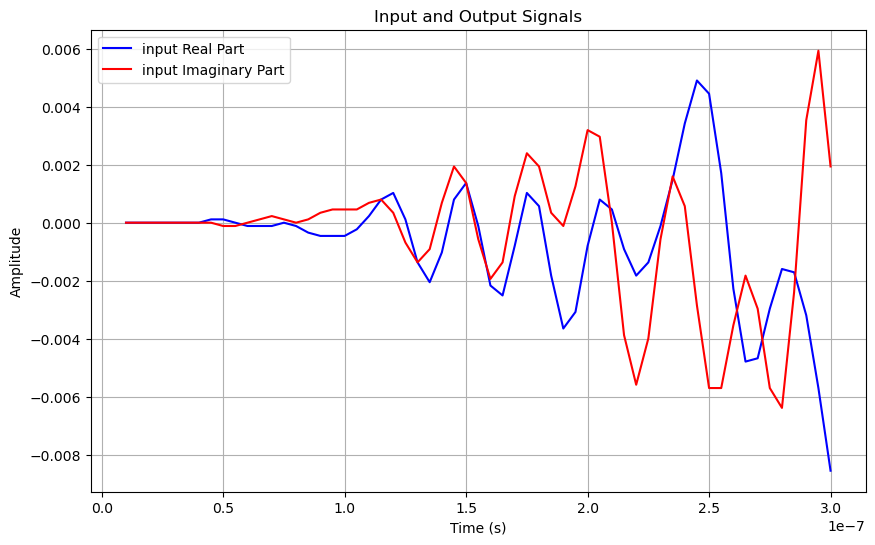

In [16]:
draw_plot_signal('input', time_start=1e-8, time_end=0.3e-6)

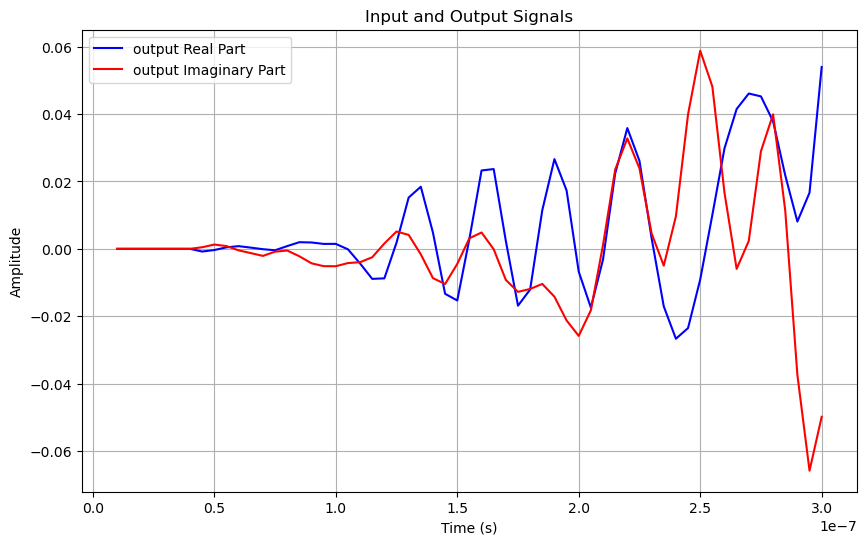

In [17]:
draw_plot_signal('output', time_start=1e-8, time_end=0.3e-6)

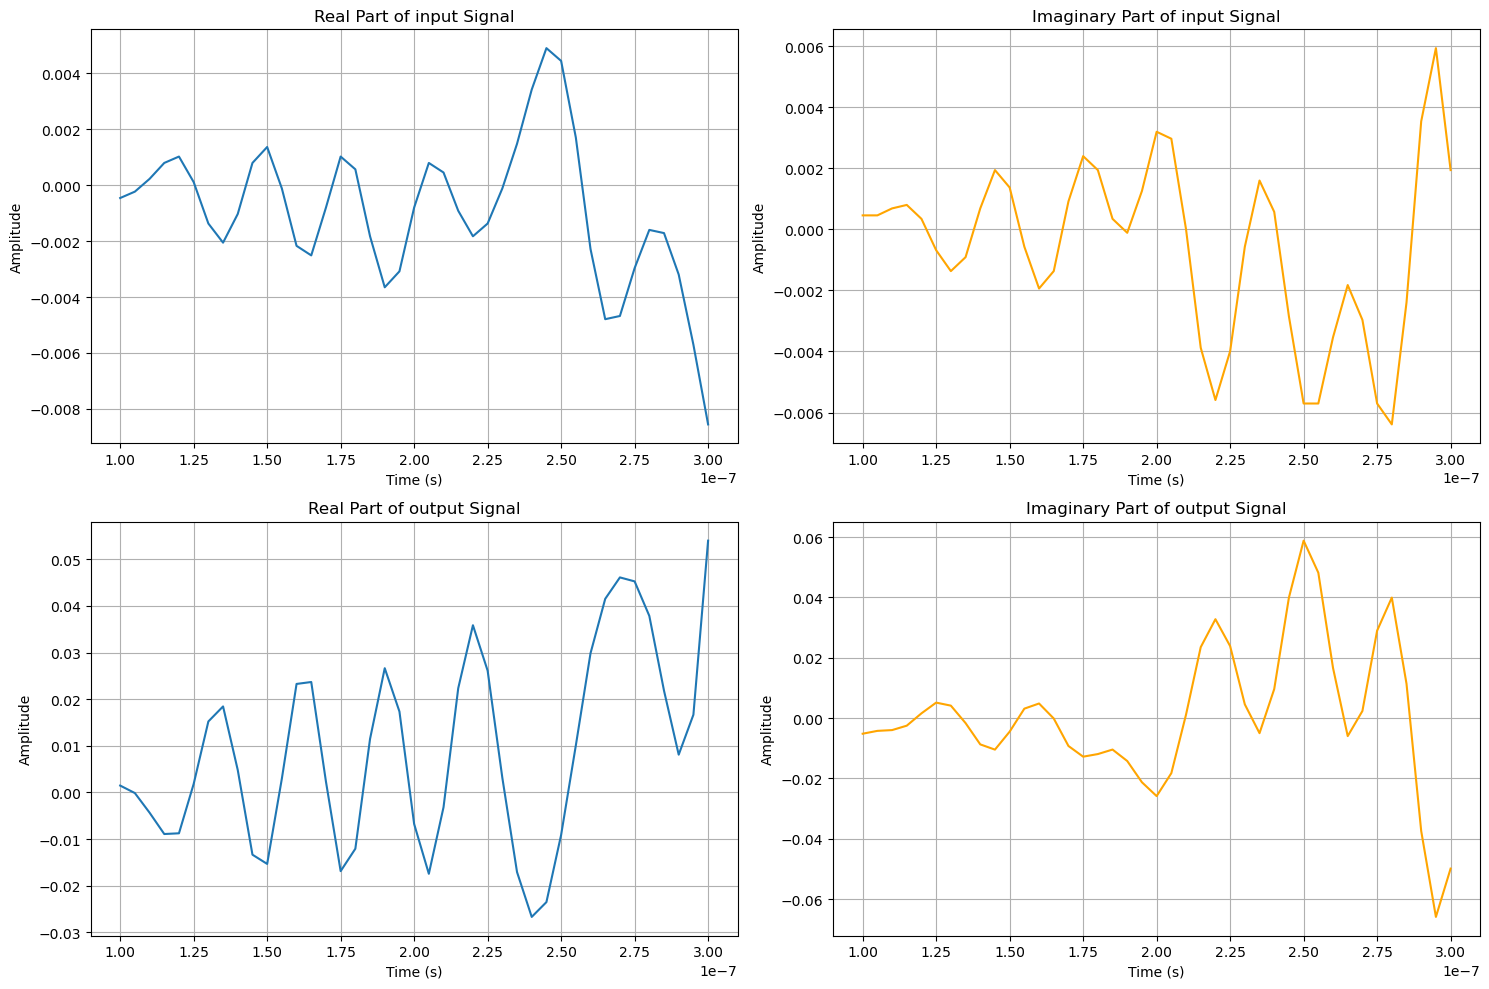

In [18]:
draw_all_plot_signal(time_start=1e-7, time_end=0.3e-6)

# Нейронное обучение

In [19]:
# Здесь будем сохранить результаты обучения
results = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172032 entries, 0.0 to 0.000860155
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   input_real   172032 non-null  float64
 1   input_imag   172032 non-null  float64
 2   output_real  172032 non-null  float64
 3   output_imag  172032 non-null  float64
dtypes: float64(4)
memory usage: 6.6 MB


In [108]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is not available. Running on CPU.


### Neural Ordinary Differential Equations (Neural ODE)

#### Инициализация класса модели

In [96]:
# Класс для обучения и оценки модели Neural ODE
class NeuralODETrainer:
    def __init__(self, df, batch_size=64, learning_rate=0.001, epochs=10, hidden_size=128, method='dopri5'):
        # Преобразуем данные
        # self.df = self.prepare_data(df)
        self.df = df
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.hidden_size = hidden_size
        self.method = method
        self.history = {"epoch": [], "rmse": []}  # История обучения

        # Подготовка датасета и DataLoader
        self.dataset = self.TimeSeriesDataset(self.df)
        self.train_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, pin_memory=True)
        
        # Инициализация модели
        self.model = self.NeuralODEModel(hidden_size=self.hidden_size).to(self.get_device())
        self.criterion = nn.MSELoss()  # Используем MSE как функцию потерь
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    # Метод для преобразования данных в нужный формат
    @staticmethod
    def prepare_data(df):
        df['Input'] = df['Input'].apply(lambda x: complex(x))  # Преобразуем строки в комплексные числа
        df['Output'] = df['Output'].apply(lambda x: complex(x))
        df['input_real'] = df['Input'].apply(lambda x: x.real)
        df['input_imag'] = df['Input'].apply(lambda x: x.imag)
        df['output_real'] = df['Output'].apply(lambda x: x.real)
        df['output_imag'] = df['Output'].apply(lambda x: x.imag)
        df = df.drop(['Input', 'Output'], axis=1)
        df = df.set_index('Time')  # Устанавливаем временной ряд как индекс
        return df
        
    # Класс для датасета временных рядов
    class TimeSeriesDataset(Dataset):
        def __init__(self, df):
            self.inputs = df[['input_real', 'input_imag']].values
            self.outputs = df[['output_real', 'output_imag']].values
            self.time = df.index.values.astype('float32')

        def __len__(self):
            return len(self.inputs)

        def __getitem__(self, idx):
            x = torch.tensor(self.inputs[idx], dtype=torch.float32)
            y = torch.tensor(self.outputs[idx], dtype=torch.float32)
            t = torch.tensor(self.time[idx], dtype=torch.float32)
            return t, x, y

    # Класс ODE функции
    class ODEFunc(nn.Module):
        def __init__(self, hidden_size):
            super().__init__()
            self.linear = nn.Linear(hidden_size, hidden_size)
            self.relu = nn.ReLU()

        def forward(self, t, x):
            return self.relu(self.linear(x))

    # Класс модели Neural ODE
    class NeuralODEModel(nn.Module):
        def __init__(self, input_size=2, hidden_size=128, output_size=2, num_hidden_layers=2):
            super().__init__()
            self.input_layer = nn.Linear(input_size, hidden_size)
            self.hidden_layers = nn.ModuleList([
                nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)
            ])
            self.ode_func = NeuralODETrainer.ODEFunc(hidden_size)
            self.output_layer = nn.Linear(hidden_size, output_size)
            self.dropout = nn.Dropout(p=0.5)

        def forward(self, x, t):
            x = self.input_layer(x)
            for layer in self.hidden_layers:
                residual = x
                x = torch.relu(layer(x))  # Использование ReLU активации
                x = self.dropout(x)
                x += residual  # Остаточное соединение
                
            options = {
                'method': 'dopri5',  # метод решения (адаптивный шаг)
                't0': t[0].item(),  # начальное время
                't1': t[-1].item(),  # конечное время
                'rtol': 1e-9,  # относительная точность
                'atol': 1e-10,  # абсолютная точность
                'print_neval': False,  # не выводить количество итераций
                'neval_max': 1e7,  # максимальное число итераций
                't_eval': None,  # оценивать только конечное значение
                'regenerate_graph': False  # не перегенерировать граф для обратного прохода
            }
            
            x = odesolve(self.ode_func, x, options=options)
            x = self.output_layer(x)
            return x

    # Метод для получения устройства (CPU или GPU)
    @staticmethod
    def get_device():
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def train(self):
        device = self.get_device()
        self.model.train()
    
        for epoch in range(self.epochs):
            running_loss = 0.0
            rmse_total = 0.0
            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs}", unit="batch")
    
            for batch_idx, (t, inputs, targets) in enumerate(progress_bar):
                inputs, targets = inputs.to(device), targets.to(device)
                self.optimizer.zero_grad()
    
                outputs = self.model(inputs, t)
                loss = self.criterion(outputs, targets)
                rmse = torch.sqrt(loss)  # RMSE
                rmse.backward()
                self.optimizer.step()
    
                # Рассчитываем RMSE
                rmse_total += rmse.item()
    
                progress_bar.set_postfix(rmse=f"{rmse:.6f}")
    
            avg_rmse = rmse_total / len(self.train_loader)
            
            # Сохраняем метрики в историю
            self.history["epoch"].append(epoch + 1)
            self.history["rmse"].append(avg_rmse)
    
            print(f"Epoch {epoch+1}/{self.epochs} completed with RMSE: {avg_rmse:.6f}")
    
        print("Training completed!")
        self.save_training_history(self.history)

    # Метод для оценки модели
    def evaluate(self):
        self.model.eval()
        true_values = []
        predicted_values = []
        times = []
    
        with torch.no_grad():
            for t, inputs, targets in self.train_loader:
                inputs, targets = inputs.to(self.get_device()), targets.to(self.get_device())
                outputs = self.model(inputs, t)
                true_values.append(targets.cpu().numpy())
                predicted_values.append(outputs.cpu().numpy())
                times.append(t.cpu().numpy())
    
        # Конкатенация всех предсказанных значений, истинных значений и временных меток
        self.true_values = np.concatenate(true_values, axis=0)
        self.predicted_values = np.concatenate(predicted_values, axis=0)
        self.times = np.concatenate(times, axis=0)
    
        # Сортировка данных по временам
        sort_indices = np.argsort(self.times)
        self.times = self.times[sort_indices]
        self.true_values = self.true_values[sort_indices]
        self.predicted_values = self.predicted_values[sort_indices]
    
        # Сохраним предсказанные значения
        self.save_prediction(self.predicted_values)
        # Сохраним модель
        self.save_model(self.model)
        
        # Вычисление RMSE
        rmse_real = mean_squared_error(self.true_values[:, 0], self.predicted_values[:, 0], squared=False)
        rmse_imag = mean_squared_error(self.true_values[:, 1], self.predicted_values[:, 1], squared=False)

        print(f"Evaluation RMSE (Real): {rmse_real:.6f}")
        print(f"Evaluation RMSE (Imaginary): {rmse_imag:.6f}")
    
        return rmse_real, rmse_imag

    @staticmethod
    def save_model(model, filename_prefix='node', save_dir='models'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.pth"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)

        # Сохраняем ВСЮ модель
        torch.save(model.state_dict(), filepath)

    @staticmethod
    def save_prediction(predictions, filename_prefix="predictions", save_dir='history'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_predictions = pd.DataFrame({'real': predictions[:, 0], 'imag': predictions[:, 1],})
        df_predictions.to_csv(filepath, index=False)
        print(f"Training history saved to {filepath}")

    @staticmethod
    def save_training_history(history, filename_prefix="training_history", save_dir='history'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_history = pd.DataFrame(history)
        df_history.to_csv(filepath, index=False)
        print(f"Training history saved to {filepath}")

    def plot_training_history(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
    
        # Первый график: Полная история
        axs[0].plot(epochs, self.history["rmse"], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        # Второй график: RMSE
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()

        # Второй график: Половина истории
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], self.history["rmse"][mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average RMSE')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, time_start=0, time_end=1.005e2):
        # Убедимся, что данные были вычислены в evaluate()
        if not hasattr(self, 'true_values') or not hasattr(self, 'predicted_values') or not hasattr(self, 'times'):
            raise ValueError("You must run evaluate() before plotting predictions.")
    
        # Фильтрация данных по времени
        mask = (self.times >= time_start) & (self.times <= time_end)
        filtered_times = self.times[mask]
        filtered_true_values = self.true_values[mask]
        filtered_predicted_values = self.predicted_values[mask]
    
        # Построение графика для реальных значений
        plt.figure(figsize=(20, 5))
    
        plt.subplot(1, 2, 1)  # 1 ряд, 2 колонки, 1-й график
        plt.plot(filtered_times, filtered_true_values[:, 0], label="True Real", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_predicted_values[:, 0], label="Predicted Real", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Real Values")
        plt.xlabel("Time")
        plt.ylabel("Real Value")
    
        # Построение графика для мнимых значений
        plt.subplot(1, 2, 2)  # 1 ряд, 2 колонки, 2-й график
        plt.plot(filtered_times, filtered_true_values[:, 1], label="True Imag", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_predicted_values[:, 1], label="Predicted Imag", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Imaginary Values")
        plt.xlabel("Time")
        plt.ylabel("Imaginary Value")
    
        plt.tight_layout()
        plt.show()

    def cross_validate(self, param_grid, cv=5):
        # Разделение данных на входы и выходы
        X = self.dataset.inputs
        y = self.dataset.outputs
    
        # Определение модели для кросс-валидации
        model = self.NeuralODEModel(hidden_size=self.hidden_size)
    
        # Использование GridSearchCV для поиска лучших гиперпараметров
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
        grid_search.fit(X, y)
    
        print("Best parameters found: ", grid_search.best_params_)
        print("Best score (RMSE): ", -grid_search.best_score_)

#### Установка параметров

In [97]:
batch_size=1024*1
learning_rate=1e-4
epochs=2
hidden_size=256

In [98]:
# Создание экземпляра класса с настройкой гиперпараметров
NODE_model = NeuralODETrainer(df, batch_size, learning_rate, epochs, hidden_size)

#### Обучение модели

In [99]:
%%time
# Обучение модели
NODE_model.train()

Epoch 1/2:   0%|          | 0/168 [00:00<?, ?batch/s]

Epoch 1/2 completed with RMSE: 0.827879


Epoch 2/2:   0%|          | 0/168 [00:00<?, ?batch/s]

Epoch 2/2 completed with RMSE: 0.451299
Training completed!
Training history saved to history/training_history_20241006_123317.csv
CPU times: user 3min 45s, sys: 9.37 s, total: 3min 55s
Wall time: 29.5 s


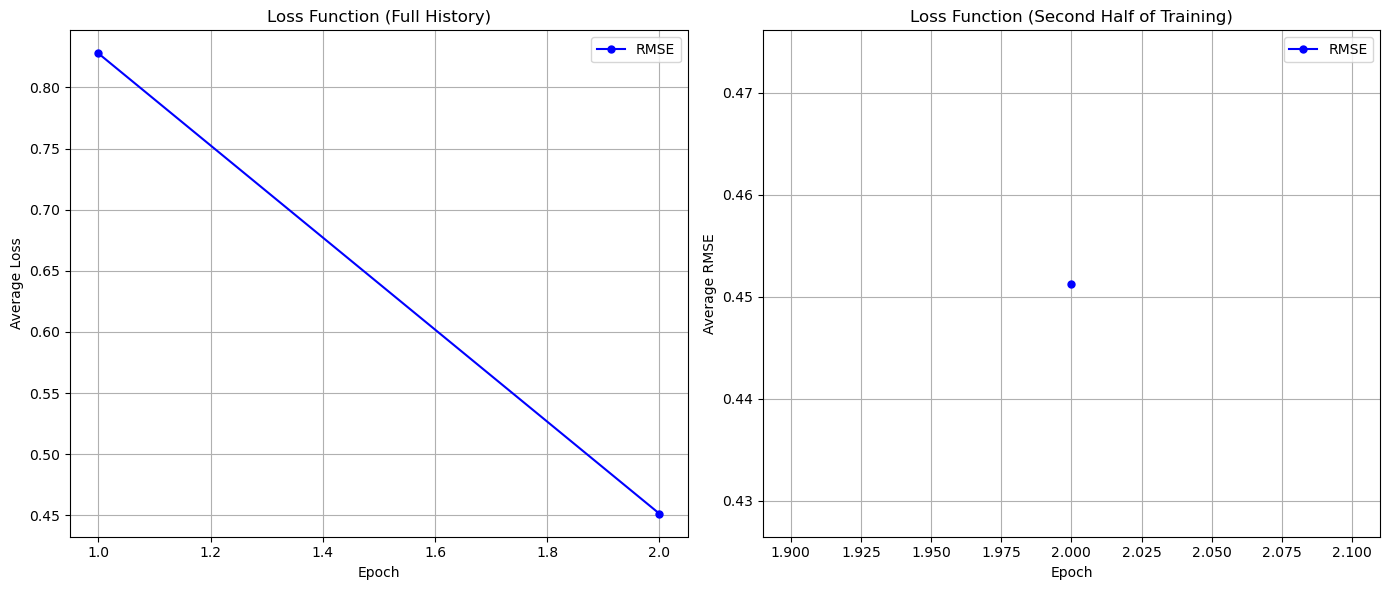

In [100]:
NODE_model.plot_training_history()

#### Предсказание и сохранение модели после обучения

In [101]:
%%time
# Оценка модели
NODE_model.evaluate()

Training history saved to history/predictions_20241006_123329.csv
Evaluation RMSE (Real): 0.264228
Evaluation RMSE (Imaginary): 0.265337
CPU times: user 1min 24s, sys: 3.7 s, total: 1min 27s
Wall time: 11.1 s


(0.26422846, 0.26533663)

#### Демонстрация

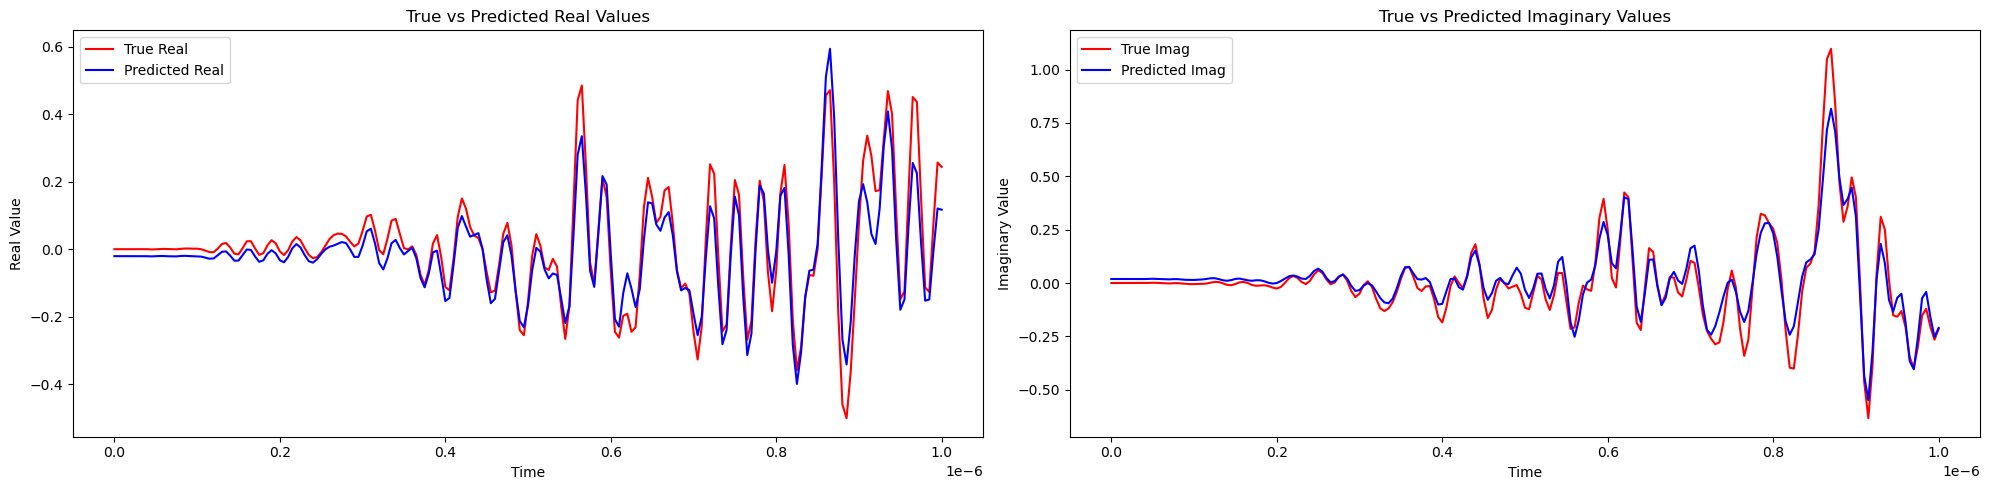

CPU times: user 268 ms, sys: 4.01 ms, total: 272 ms
Wall time: 270 ms


In [102]:
%%time
NODE_model.plot_predictions(time_start=0, time_end=0.1e-5)

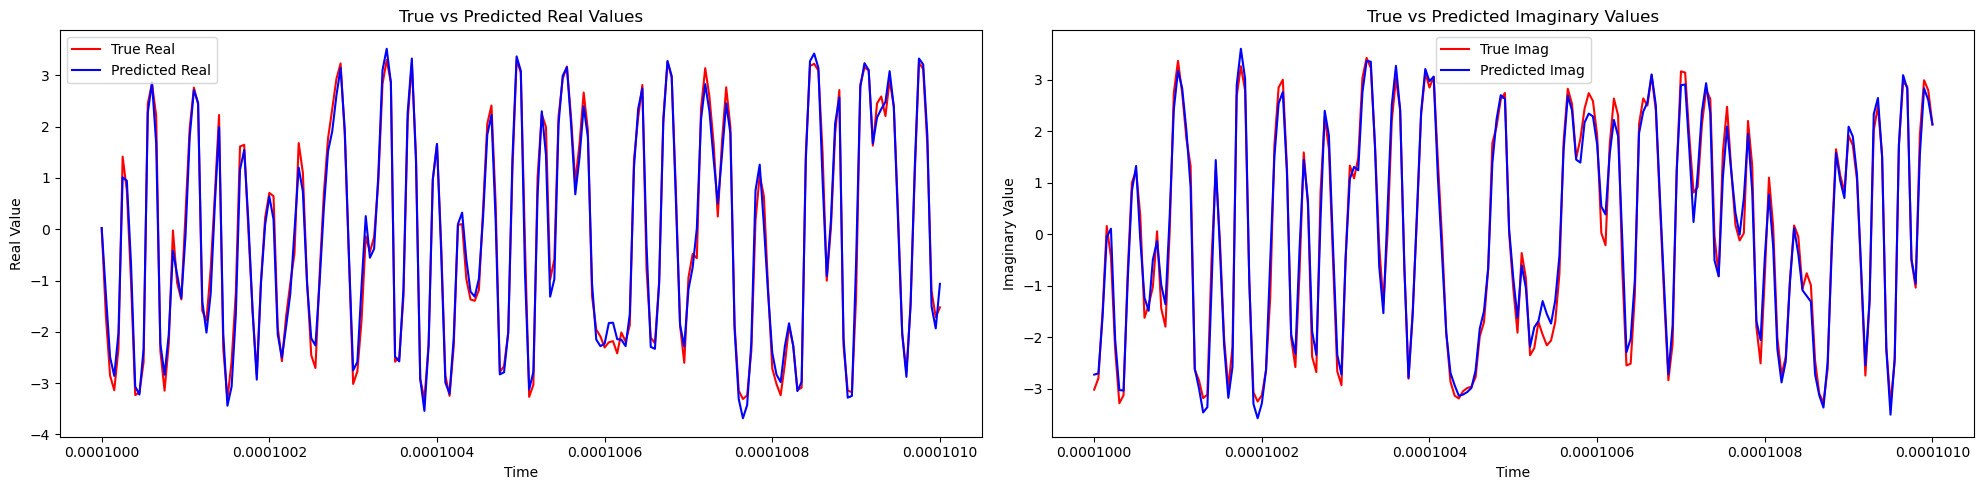

CPU times: user 266 ms, sys: 5.05 ms, total: 271 ms
Wall time: 270 ms


In [104]:
%%time
NODE_model.plot_predictions(time_start=1e-4, time_end=1.01e-4)

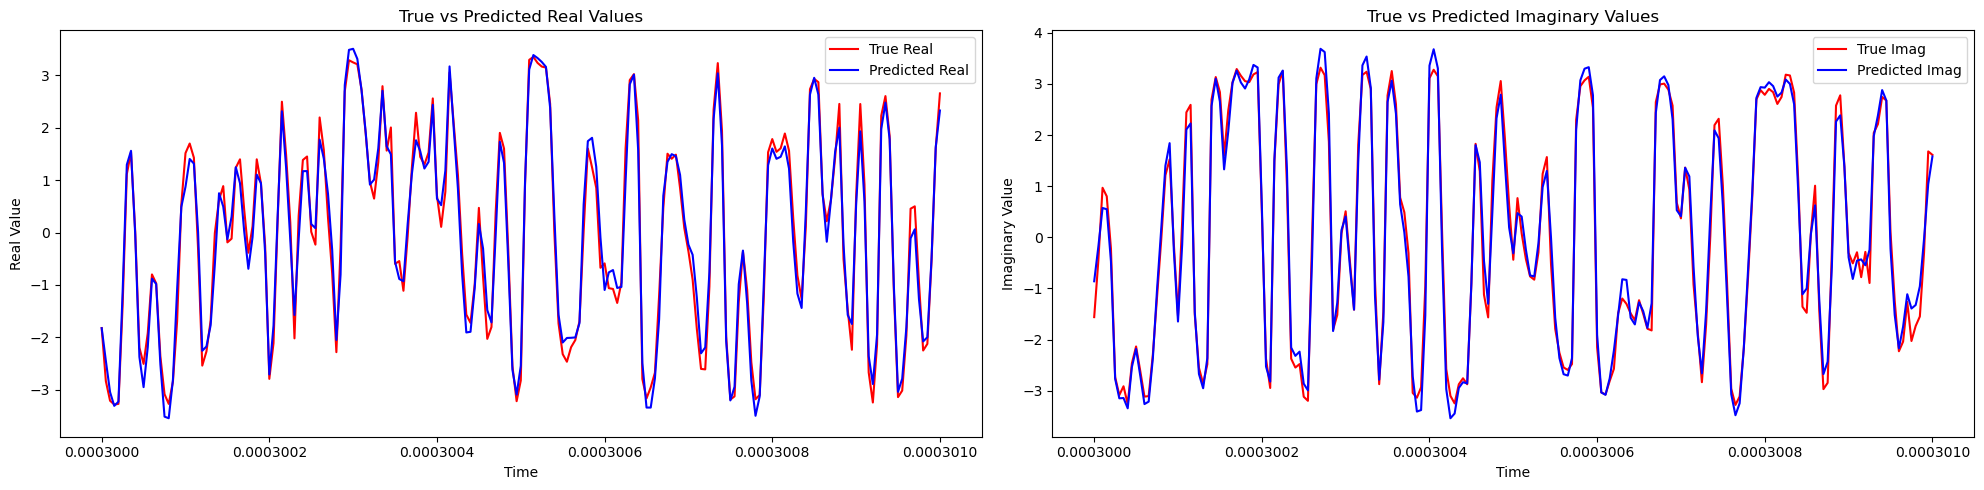

CPU times: user 270 ms, sys: 3.04 ms, total: 273 ms
Wall time: 271 ms


In [105]:
%%time
NODE_model.plot_predictions(time_start=3e-4, time_end=3.01e-4)

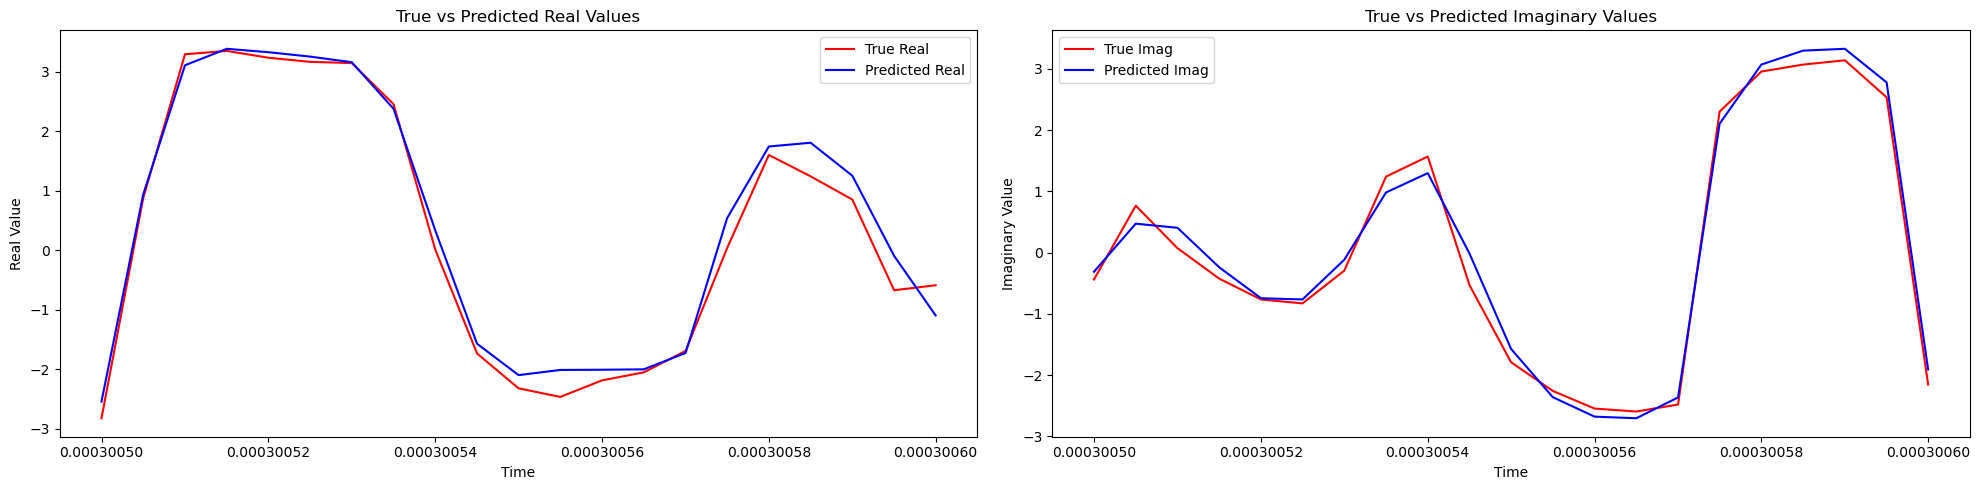

CPU times: user 244 ms, sys: 6.97 ms, total: 251 ms
Wall time: 249 ms


In [106]:
%%time
NODE_model.plot_predictions(time_start=3.005e-4, time_end=3.006e-4)

## Результаты

In [50]:
results = pd.DataFrame(results).T

In [51]:
# Смотрим на результаты
display(results)

,NAME,RMSE VALID REAL,RMSE VALID IMAG,TIME TRAINING [s],PREDICTIONS,PARAMETRS
0,CTDRNN,0.052387,0.051747,578.968915,"[[-0.025128674, -0.002282036], [-0.024352005, ...","{'lstm.weight_ih_l0': [[tensor(0.0078), tensor..."
1,CTDNN,0.025989,0.036186,151.687136,"[[-0.031535067, 0.041036174], [-0.030686615, 0...","{'fcs.0.weight': [[tensor(-0.0956, device='cud..."


In [52]:
# Рассчитываем рейтинг с учетом указанных приоритетов
results['RATING'] = (
    0.45 * (1 - (results['RMSE VALID REAL'] / results['RMSE VALID REAL'].max())) +
    0.45 * (1 - (results['RMSE VALID IMAG'] / results['RMSE VALID IMAG'].max())) +
    0.1 * (1 - (results['TIME TRAINING [s]'] / results['TIME TRAINING [s]'].max()))
)

# Сортируем DataFrame по убыванию рейтинга
results = results.sort_values(by='RATING', ascending=False)

In [53]:
# Смотрим на результаты
display(results)

,NAME,RMSE VALID REAL,RMSE VALID IMAG,TIME TRAINING [s],PREDICTIONS,PARAMETRS,RATING
1,CTDNN,0.025989,0.036186,151.687136,"[[-0.031535067, 0.041036174], [-0.030686615, 0...","{'fcs.0.weight': [[tensor(-0.0956, device='cud...",0.435877
0,CTDRNN,0.052387,0.051747,578.968915,"[[-0.025128674, -0.002282036], [-0.024352005, ...","{'lstm.weight_ih_l0': [[tensor(0.0078), tensor...",0.0
